### Import Library

In [30]:
import time
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, SAGEConv
from torch_geometric.data import Data
from torch_geometric.nn import global_mean_pool
import torch_scatter

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx


import random

from pathlib import Path

In [ ]:
project_root = Path("C://Users//DELL//Desktop//the-year-25-26//scalable-graph-based-movie-recommender")

In [32]:
ratings = pd.read_csv(project_root / 'data' / 'processed' / 'ratings_gnn.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,1225734739
1,1,110,4.0,1225865086
2,1,158,4.0,1225733503
3,1,260,4.5,1225735204
4,1,356,5.0,1225735119


In [33]:
movies = pd.read_csv(project_root / 'data' / 'processed' / 'movies_gnn.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [35]:
tags = pd.read_csv(project_root / 'data' / 'processed' / 'tags_gnn.csv')
tags.head()

,userId,movieId,tag,timestamp
0,302,3863,atmospheric,1476691609
1,302,3863,beautiful cinematography,1476691614
2,302,3863,stylized,1476691602
3,302,4226,great ending,1476691644
4,302,4226,psychological,1476691635


In [36]:
genome_scores= pd.read_csv(project_root / 'data' / 'processed' / 'genome_scores_gnn.csv')
genome_scores.head()

,movieId,tagId,relevance
0,1,1,0.03200
1,1,2,0.02225
2,1,3,0.07000
3,1,4,0.05900
4,1,5,0.12300


In [37]:
genome_tags= pd.read_csv(project_root / 'data' / 'processed' / 'genome_tags_gnn.csv')
genome_tags.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [38]:
print("Ratings shape:", ratings.shape)
print("Movies shape:", movies.shape)
print("Tags shape:", tags.shape)
print("Genome Tags shape:", genome_tags.shape)
print("Genome Scores shape:", genome_scores.shape)

Ratings shape: (2609897, 4)
Movies shape: (5979, 3)
Tags shape: (487354, 4)
Genome Tags shape: (1128, 2)
Genome Scores shape: (6744312, 3)


###  Dense Bipartite Network

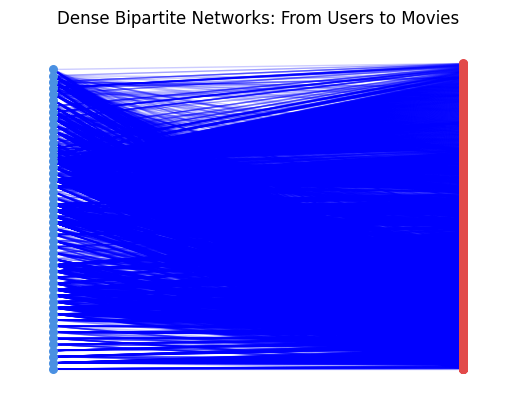

In [39]:
# Sample 50 users
sample = ratings[ratings["userId"].isin(
    random.sample(list(ratings["userId"].unique()), 50)
)]
G = nx.from_pandas_edgelist(sample, "userId", "movieId")

# After building G, ensure layout includes all nodes
user_nodes = [n for n in G.nodes() if n in sample["userId"].values]
movie_nodes = [n for n in G.nodes() if n in sample["movieId"].values]

# Create positions for all nodes in G
pos = {n: (0, i / len(user_nodes)) for i, n in enumerate(user_nodes)}
pos.update({n: (1, i / len(movie_nodes)) for i, n in enumerate(movie_nodes)})

# Draw
nx.draw_networkx_edges(G, pos, alpha=0.2, edge_color="blue")
nx.draw_networkx_nodes(G, pos, nodelist=user_nodes, node_color="#4a90e2", node_size=30)
nx.draw_networkx_nodes(G, pos, nodelist=movie_nodes, node_color="#e24a4a", node_size=30)


plt.title("Dense Bipartite Networks: From Users to Movies")
plt.axis('off')

#plt.savefig("bipartite_network.png", dpi=300, bbox_inches='tight')
plt.show()

### Data Prep

In [40]:
user_ids = ratings['userId'].unique()
movie_ids = ratings['movieId'].unique()
num_users = len(user_ids)
num_movies = len(movie_ids)

# Map original IDs to continuous indices
user_mapping = {id: idx for idx, id in enumerate(user_ids)}
movie_mapping = {id: idx for idx, id in enumerate(movie_ids)}

ratings['user_idx'] = ratings['userId'].map(user_mapping)
ratings['movie_idx'] = ratings['movieId'].map(movie_mapping)

In [41]:
# Filter content data
tags_filtered = tags[tags['movieId'].isin(movie_ids)]
genome_scores_filtered = genome_scores[genome_scores['movieId'].isin(movie_ids)]

# Create content features (reduce genome dimensionality)
from scipy.sparse import csc_matrix
genome_matrix = csc_matrix(
    (genome_scores_filtered['relevance'].values,
     (genome_scores_filtered['movieId'].map(movie_mapping).values,
      genome_scores_filtered['tagId'].values)),
    shape=(num_movies, genome_tags['tagId'].max() + 1)
).toarray()

genome_matrix

array([[0.     , 0.032  , 0.02225, ..., 0.033  , 0.077  , 0.01825],
       [0.     , 0.0525 , 0.031  , ..., 0.08975, 0.0895 , 0.0235 ],
       [0.     , 0.03275, 0.04125, ..., 0.008  , 0.10025, 0.01475],
       ...,
       [0.     , 0.02975, 0.03075, ..., 0.0065 , 0.106  , 0.0165 ],
       [0.     , 0.03125, 0.03425, ..., 0.00575, 0.087  , 0.01175],
       [0.     , 0.04125, 0.044  , ..., 0.00625, 0.1225 , 0.01775]],
      shape=(5979, 1129))

In [42]:
# Reduce genome features to 64 dimensions
from sklearn.decomposition import PCA
pca = PCA(n_components=64)
genome_features_reduced = pca.fit_transform(genome_matrix)
movie_content_features = torch.tensor(genome_features_reduced, dtype=torch.float)
movie_content_features

tensor([[ 0.7972,  1.0766,  3.0914,  ..., -0.0279,  0.0226, -0.5266],
        [ 3.4215,  2.6226,  3.4195,  ..., -0.0781, -0.0202, -0.4100],
        [-2.0368, -0.5413,  1.1547,  ...,  0.3976, -0.0443,  0.1703],
        ...,
        [ 0.2418, -1.2308, -0.5988,  ...,  0.0539,  0.0588, -0.1326],
        [-1.8002, -0.9215,  0.0156,  ..., -0.1313,  0.0298, -0.1194],
        [-1.3067, -0.4033, -0.9003,  ...,  0.1759,  0.0661, -0.1520]])

In [43]:
# Create features for both users and movies with same dimension
base_features = torch.randn(num_users + num_movies, 64)
user_features = base_features[:num_users]  # 64-dim users
movie_features = base_features[num_users:] + 0.1 * movie_content_features  # 64-dim movies with content bias

# Combine features (same dimension for both)
x = torch.cat([user_features, movie_features], dim=0)  # [num_users + num_movies, 64]
x

tensor([[ 0.3076, -2.3540, -0.0580,  ..., -1.2816,  0.2390,  0.4330],
        [ 1.6074, -0.1805, -1.3898,  ...,  0.6596, -0.7372,  1.6849],
        [-0.2495,  0.0111, -1.1519,  ..., -0.3523, -1.1976,  1.2290],
        ...,
        [ 1.1802, -0.8729,  0.0738,  ..., -0.1239, -1.5296,  0.2121],
        [-0.7922,  1.0919, -1.4825,  ...,  0.7142, -1.2218, -0.9508],
        [-0.0148, -1.7638, -2.5442,  ..., -0.8681,  0.0525,  1.9732]])

In [44]:
# Create a bipartite graph
user_idx = ratings['user_idx'].values
movie_idx = ratings['movie_idx'].values + num_users

edge_index_np = np.column_stack([
    np.concatenate([user_idx, movie_idx]),
    np.concatenate([movie_idx, user_idx])
]).T

edge_index = torch.from_numpy(edge_index_np)
ratings_tensor = torch.tensor(ratings['rating'].values, dtype=torch.float)
edge_attr = torch.cat([ratings_tensor, ratings_tensor])

from torch_geometric.data import Data
data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
print(data)

Data(x=[20979, 64], edge_index=[2, 5219794], edge_attr=[5219794])


- save data prep

In [45]:
import os
os.makedirs('../models', exist_ok=True) 

# Save data preparation for reuse
torch.save({
    'data': data,
    'user_mapping': user_mapping,
    'movie_mapping': movie_mapping,
    'pca_model': pca  # To transform new movies
}, '../models/preprocessed_data.pt')

### Setup

In [46]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        
    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False  # Continue training
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True  # Stop training
            return False

In [47]:
# Data splitting 
shuffled_idx = np.random.permutation(len(ratings))
train_idx, temp_idx = train_test_split(shuffled_idx, test_size=0.2, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)

In [48]:
# Convert to tensors 
train_users = torch.tensor(ratings.iloc[train_idx]['user_idx'].values, dtype=torch.long)
train_movies = torch.tensor(ratings.iloc[train_idx]['movie_idx'].values, dtype=torch.long)
train_ratings_tensor = torch.tensor(ratings.iloc[train_idx]['rating'].values, dtype=torch.float)

val_users = torch.tensor(ratings.iloc[val_idx]['user_idx'].values, dtype=torch.long)
val_movies = torch.tensor(ratings.iloc[val_idx]['movie_idx'].values, dtype=torch.long)
val_ratings_tensor = torch.tensor(ratings.iloc[val_idx]['rating'].values, dtype=torch.float)

test_users = torch.tensor(ratings.iloc[test_idx]['user_idx'].values, dtype=torch.long)
test_movies = torch.tensor(ratings.iloc[test_idx]['movie_idx'].values, dtype=torch.long)
test_ratings_tensor = torch.tensor(ratings.iloc[test_idx]['rating'].values, dtype=torch.float)

In [49]:
def evaluate_model(model, users, movies, ratings_true, model_type='mf'):
    model.eval()
    with torch.no_grad():
        if model_type == 'mf':
            pred = model(users, movies)
        elif model_type == 'lightgcn':  # Note: this is the original LightGCN, not rating version
            user_embs, movie_embs = model(data.edge_index)
            pred = (user_embs[users] * movie_embs[movies]).sum(dim=1)
        else:  # graphsage and graphrec
            pred = model(data.x, data.edge_index, users, movies + num_users)
        
        rmse = torch.sqrt(F.mse_loss(pred, ratings_true))
        mae = F.l1_loss(pred, ratings_true)
    return rmse.item(), mae.item()

### Neural Matrix Factorization

In [21]:
# Model Family: Matrix factorization
# Architecture:  Neural Network
# Variant: Generalized Matrix Factorization (GMF)
# Use Case: Collaborative Filtering

class MatrixFactorization(nn.Module):
    def __init__(self, num_users, num_movies, embed_dim=64, dropout_rate=0.1):
        super().__init__()
        self.user_embed = nn.Embedding(num_users, embed_dim)
        self.movie_embed = nn.Embedding(num_movies, embed_dim)
        self.dropout = nn.Dropout(dropout_rate)  # Add dropout
        nn.init.normal_(self.user_embed.weight, std=0.1)
        nn.init.normal_(self.movie_embed.weight, std=0.1)
        
    def forward(self, user_idx, movie_idx):
        user_vec = self.dropout(self.user_embed(user_idx)) 
        movie_vec = self.dropout(self.movie_embed(movie_idx))
        return (user_vec * movie_vec).sum(dim=1)

In [22]:
# Train MF with early stopping
mf_model = MatrixFactorization(num_users, num_movies, embed_dim=64, dropout_rate=0.2)
mf_optimizer = torch.optim.Adam(mf_model.parameters(), lr=0.01)
early_stopper = EarlyStopping(patience=5, min_delta=0.001)

In [23]:
import time

In [24]:
# Create the models directory in the parent folder
os.makedirs('../models', exist_ok=True)

# Start timing
start_time = time.time()

#training loop
best_val_rmse = float('inf')
patience_counter = 0

train_losses = []
train_rmses = []
val_rmses = []
epochs_recorded = []
model_saved = False  # Track if model was saved

# Create progress bar
pbar = tqdm(range(100), desc="Training MF")

for epoch in pbar:
    mf_model.train()
    mf_optimizer.zero_grad()
    
    pred = mf_model(train_users, train_movies)
    loss = F.mse_loss(pred, train_ratings_tensor)
    loss.backward()
    mf_optimizer.step()
    
    if epoch % 5 == 0:
        train_rmse, train_mae = evaluate_model(mf_model, train_users, train_movies, train_ratings_tensor, 'mf')
        val_rmse, val_mae = evaluate_model(mf_model, val_users, val_movies, val_ratings_tensor, 'mf')
        
        # Store metrics
        train_losses.append(loss.item())
        train_rmses.append(train_rmse)
        val_rmses.append(val_rmse)
        epochs_recorded.append(epoch)
        
        # Update progress bar description
        pbar.set_postfix({
            'Train_RMSE': f'{train_rmse:.4f}',
            'Val_RMSE': f'{val_rmse:.4f}',
            'Loss': f'{loss.item():.4f}',
            'Time': f'{time.time() - start_time:.2f}s'
        })
        
        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            torch.save(mf_model.state_dict(), '../best_mf_model.pth')
            model_saved = True
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= 5:
            pbar.set_description(f"Early stopping at epoch {epoch}")
            break

pbar.close()

# save the final model
if not model_saved:
    torch.save(mf_model.state_dict(), '../models/best_mf_model.pth')

total_training_time = time.time() - start_time
print(f"\nTotal training time: {total_training_time:.2f} seconds")

Training MF: 100%|██████████| 100/100 [04:10<00:00,  2.50s/it, Train_RMSE=0.7742, Val_RMSE=0.8240, Loss=0.7857, Time=240.17s]


Total training time: 250.38 seconds


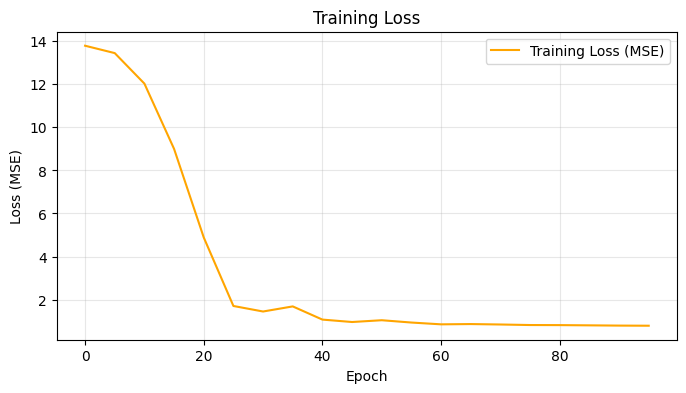

In [25]:
# Plot 1: Loss
plt.figure(figsize=(8, 4))
plt.plot(epochs_recorded, train_losses, label='Training Loss (MSE)',color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

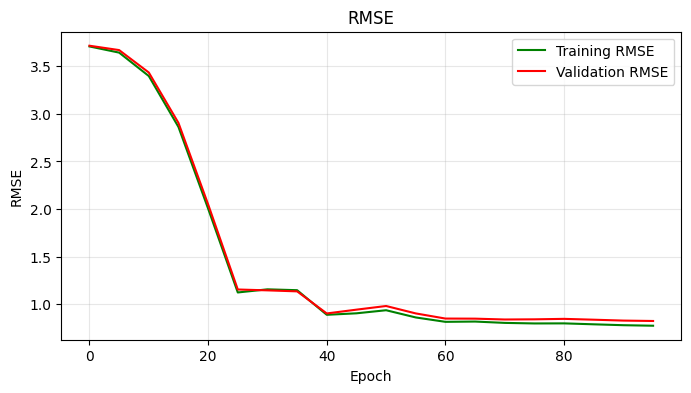

In [26]:
# Plot 2: RMSE
plt.figure(figsize=(8, 4))
plt.plot(epochs_recorded, train_rmses, label='Training RMSE',color='green')
plt.plot(epochs_recorded, val_rmses, label='Validation RMSE', color='red')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('RMSE')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### test set eval

In [27]:
# Load best model
mf_model.load_state_dict(torch.load('../models/best_mf_model.pth', weights_only=True))
mf_test_rmse, mf_test_mae = evaluate_model(mf_model, test_users, test_movies, test_ratings_tensor, 'mf')
print(f"MF Test RMSE: {mf_test_rmse:.4f}, MAE: {mf_test_mae:.4f}")

MF Test RMSE: 0.7801, MAE: 0.5942


### LightGCN

In [40]:
# Model Family: Graph Neural Networks
# Architecture: Neural Network
# Variant: Light Graph Convolutional Network (LightGCN)
# Use Case: Collaborative Filtering

class LightGCN_Rating(nn.Module):
    def __init__(self, num_users, num_movies, embed_dim=64, num_layers=2):
        super().__init__()
        self.num_users = num_users
        self.num_movies = num_movies
        self.embed_dim = embed_dim
        self.num_layers = num_layers
        
        # User and movie embeddings
        self.user_embed = nn.Embedding(num_users, embed_dim)
        self.movie_embed = nn.Embedding(num_movies, embed_dim)
        
        # Learnable layer weights (LightGCN paper)
        self.layer_weights = nn.Parameter(torch.ones(num_layers + 1) / (num_layers + 1))
        
        # Rating prediction head
        self.rating_predictor = nn.Sequential(
            nn.Linear(embed_dim * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
        # Initialize embeddings
        nn.init.xavier_uniform_(self.user_embed.weight)
        nn.init.xavier_uniform_(self.movie_embed.weight)
        
    def forward(self, edge_index, user_idx, movie_idx):
        # Get initial embeddings
        user_embs = self.user_embed.weight
        movie_embs = self.movie_embed.weight
        all_embs = torch.cat([user_embs, movie_embs], dim=0)
        
        # Store embeddings for each layer
        embs_list = [all_embs]
        
        # Propagate through graph layers
        for _ in range(self.num_layers):
            all_embs = self.propagate(edge_index, all_embs)
            embs_list.append(all_embs)
        
        # Weighted sum of embeddings across layers (LightGCN style)
        final_embs = torch.stack(embs_list, dim=0)  # [num_layers+1, num_nodes, embed_dim]
        weighted_embs = torch.sum(
            self.layer_weights.unsqueeze(1).unsqueeze(2) * final_embs, 
            dim=0
        )
        
        # Get user and movie representations
        user_repr = weighted_embs[user_idx]
        movie_repr = weighted_embs[movie_idx + self.num_users]  # Add offset to access movie embeddings
        
        # Concatenate and predict rating
        rating_input = torch.cat([user_repr, movie_repr], dim=1)
        rating = self.rating_predictor(rating_input).squeeze()
        
        # Scale rating to appropriate range (adjust based on your data)
        rating = torch.sigmoid(rating) * 4 + 1  # Scales to [1, 5] range
        
        return rating
    
    def propagate(self, edge_index, x):
        row, col = edge_index
        deg = torch_scatter.scatter_add(torch.ones_like(row), row, dim=0, dim_size=x.size(0))
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        out = torch_scatter.scatter_add(x[col] * norm.unsqueeze(1), row, dim=0, dim_size=x.size(0))
        return out

In [ ]:
# Rebuild edge index properly
user_idx_np = ratings['user_idx'].values
movie_idx_np = ratings['movie_idx'].values  

# Make sure movie indices start from num_users
movie_idx_offset = movie_idx_np + num_users

edge_index_proper_np = np.column_stack([
    np.concatenate([user_idx_np, movie_idx_offset]),
    np.concatenate([movie_idx_offset, user_idx_np])
]).T

edge_index_proper = torch.from_numpy(edge_index_proper_np)

print(f"Proper edge_index: {edge_index_proper.shape}")
print(f"First few proper edges: {edge_index_proper[:, :5]}")

Proper edge_index: torch.Size([2, 5219794])
First few proper edges: tensor([[    0,     0,     0,     0,     0],
        [15000, 15001, 15002, 15003, 15004]])


In [41]:
# Update evaluate_model function 
def evaluate_model_rating(model, users, movies, ratings_true, model_type='lightgcn_rating'):
    model.eval()
    with torch.no_grad():
        if model_type == 'lightgcn_rating':
            # Pass raw indices - model handles offset internally
            pred = model(edge_index_proper, users, movies)
        else:
            # Your original evaluation logic here
            if model_type == 'mf':
                pred = model(users, movies)
            elif model_type == 'lightgcn':
                user_embs, movie_embs = model(edge_index_proper)
                pred = (user_embs[users] * movie_embs[movies]).sum(dim=1)
        
        rmse = torch.sqrt(F.mse_loss(pred, ratings_true))
        mae = F.l1_loss(pred, ratings_true)
    return rmse.item(), mae.item()

In [42]:
# Train the rating-aware LightGCN
rating_model = LightGCN_Rating(num_users, num_movies, embed_dim=64, num_layers=3)
rating_optimizer = torch.optim.AdamW(
    rating_model.parameters(), 
    lr=0.0015,  # Slightly higher learning rate
    weight_decay=1e-4
)

In [43]:
# Create the models directory in the parent folder
os.makedirs('../models', exist_ok=True)

# Start timing
start_time = time.time()

best_val_rmse = float('inf')
patience = 15
patience_counter = 0

train_losses = []
train_rmses = []
val_rmses = []
epochs_recorded = []
model_saved = False

pbar = tqdm(range(200), desc="Training Rating LightGCN")

for epoch in pbar:
    rating_model.train()
    rating_optimizer.zero_grad()
    
    # Pass raw indices - model handles offset internally
    pred = rating_model(edge_index_proper, train_users, train_movies)
    loss = F.mse_loss(pred, train_ratings_tensor)
    
    # Add gradient clipping
    loss.backward()
    torch.nn.utils.clip_grad_norm_(rating_model.parameters(), max_norm=1.0)
    rating_optimizer.step()
    
    if epoch % 10 == 0:
        rating_model.eval()
        with torch.no_grad():
            train_rmse, train_mae = evaluate_model_rating(
                rating_model, train_users, train_movies, train_ratings_tensor, 'lightgcn_rating'
            )
            val_rmse, val_mae = evaluate_model_rating(
                rating_model, val_users, val_movies, val_ratings_tensor, 'lightgcn_rating'
            )
        
        # Store metrics
        train_losses.append(loss.item())
        train_rmses.append(train_rmse)
        val_rmses.append(val_rmse)
        epochs_recorded.append(epoch)
        
        # Update progress bar
        pbar.set_postfix({
            'Train_RMSE': f'{train_rmse:.4f}',
            'Val_RMSE': f'{val_rmse:.4f}',
            'Loss': f'{loss.item():.4f}',
            'Time': f'{time.time() - start_time:.2f}s'
        })
        
        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            torch.save(rating_model.state_dict(), '../models/best_rating_lightgcn_model.pth')
            model_saved = True
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            pbar.set_description(f"Early stopping at epoch {epoch}")
            break

pbar.close()

# Final model save
if not model_saved:
    torch.save(rating_model.state_dict(), '../models/best_rating_lightgcn_model.pth')

total_training_time = time.time() - start_time
print(f"\nTotal training time: {total_training_time:.2f} seconds")

Training Rating LightGCN:   0%|          | 0/200 [00:00<?, ?it/s]

Training Rating LightGCN: 100%|██████████| 200/200 [1:00:02<00:00, 18.01s/it, Train_RMSE=0.8051, Val_RMSE=0.8201, Loss=0.6524, Time=3454.18s]


Total training time: 3602.90 seconds


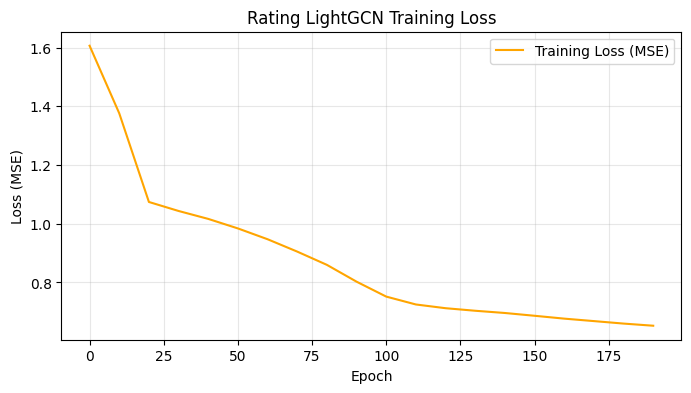

In [44]:
# Plot results
plt.figure(figsize=(8, 4))
plt.plot(epochs_recorded, train_losses, label='Training Loss (MSE)', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Rating LightGCN Training Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

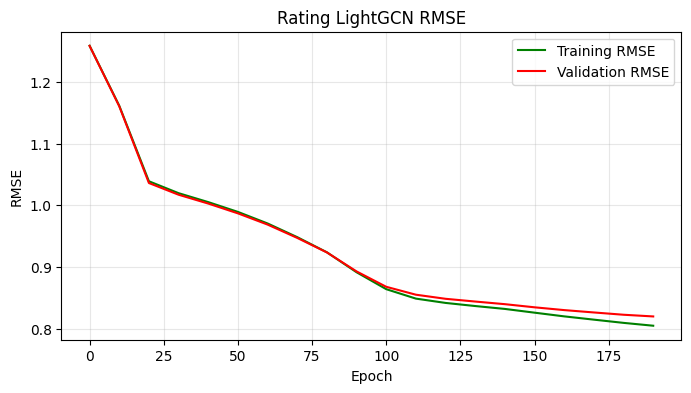

In [45]:
plt.figure(figsize=(8, 4))
plt.plot(epochs_recorded, train_rmses, label='Training RMSE',color='green')
plt.plot(epochs_recorded, val_rmses, label='Validation RMSE',color='red')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Rating LightGCN RMSE')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [46]:
# Load best model for LightGCN
rating_model.load_state_dict(torch.load('../models/best_rating_lightgcn_model.pth', weights_only=True))
lightgcn_test_rmse, lightgcn_test_mae = evaluate_model_rating(rating_model, test_users, test_movies, test_ratings_tensor, 'lightgcn_rating')
print(f"LightGCN Test RMSE: {lightgcn_test_rmse:.4f}, MAE: {lightgcn_test_mae:.4f}")

LightGCN Test RMSE: 0.8233, MAE: 0.6233


### GraphSAGE

In [49]:
# Model Family: Graph Neural Networks
# Architecture: Neural Network
# Variant: Inductive Graph Convolutional Network
# Use Case: Node Classification, Link Prediction, Recommendation Systems



class GraphSAGE_Recommender(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=32, dropout_rate=0.2):
        super().__init__()
        self.sage1 = SAGEConv(input_dim, hidden_dim)
        self.sage2 = SAGEConv(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.rating_predictor = nn.Linear(output_dim * 2, 1)
        
    def forward(self, x, edge_index, user_idx, movie_idx):
        h = self.sage1(x, edge_index).relu()
        h = self.dropout(h)
        h = self.sage2(h, edge_index)
        h = self.dropout(h)
        user_repr = h[user_idx]
        movie_repr = h[movie_idx]
        return self.rating_predictor(torch.cat([user_repr, movie_repr], dim=1)).squeeze()

In [50]:
# Train GraphSAGE
graphsage_model = GraphSAGE_Recommender(input_dim=data.x.shape[1], dropout_rate=0.3)
graphsage_optimizer = torch.optim.Adam(graphsage_model.parameters(), lr=0.001)

In [51]:

# Create the models directory in the parent folder
os.makedirs('../models', exist_ok=True)

# Start timing
start_time = time.time()

# Training loop 
best_val_rmse = float('inf')
patience_counter = 0

train_losses = []
train_rmses = []
val_rmses = []
epochs_recorded = []
model_saved = False  # Track if model was saved

pbar = tqdm(range(100), desc="Training GraphSAGE")

for epoch in pbar:
    graphsage_model.train()
    graphsage_optimizer.zero_grad()
    
    pred = graphsage_model(data.x, data.edge_index, train_users, train_movies + num_users)
    loss = F.mse_loss(pred, train_ratings_tensor)
    loss.backward()
    graphsage_optimizer.step()
    
    if epoch % 5 == 0:
        graphsage_model.eval()
        with torch.no_grad():
            train_pred = graphsage_model(data.x, data.edge_index, train_users, train_movies + num_users)
            train_rmse = torch.sqrt(F.mse_loss(train_pred, train_ratings_tensor)).item()
            
            val_pred = graphsage_model(data.x, data.edge_index, val_users, val_movies + num_users)
            val_rmse = torch.sqrt(F.mse_loss(val_pred, val_ratings_tensor)).item()
        
        # Store metrics
        train_losses.append(loss.item())
        train_rmses.append(train_rmse)
        val_rmses.append(val_rmse)
        epochs_recorded.append(epoch)
        
        # Update progress bar
        pbar.set_postfix({
            'Train_RMSE': f'{train_rmse:.4f}',
            'Val_RMSE': f'{val_rmse:.4f}',
            'Loss': f'{loss.item():.4f}',
            'Time': f'{time.time() - start_time:.2f}s'
        })
        
        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            torch.save(graphsage_model.state_dict(), '../models/best_graphsage_model.pth')
            model_saved = True
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= 5:
            pbar.set_description(f"Early stopping at epoch {epoch}")
            break

pbar.close()

if not model_saved:
    torch.save(mf_model.state_dict(), '../models/best_graphsage_model.pth')

total_training_time = time.time() - start_time
print(f"\nTotal training time: {total_training_time:.2f} seconds")

Training GraphSAGE:   0%|          | 0/100 [00:00<?, ?it/s]

Training GraphSAGE: 100%|██████████| 100/100 [07:17<00:00,  4.38s/it, Train_RMSE=1.0405, Val_RMSE=1.0387, Loss=1.2852, Time=422.87s]


Total training time: 437.68 seconds


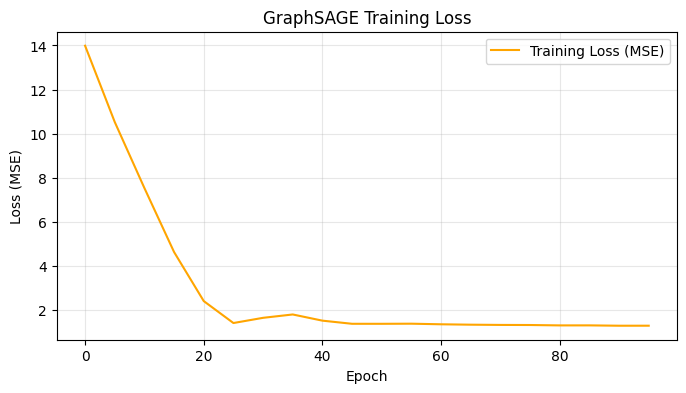

In [52]:
# Plot results
plt.figure(figsize=(8, 4))
plt.plot(epochs_recorded, train_losses, label='Training Loss (MSE)', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('GraphSAGE Training Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

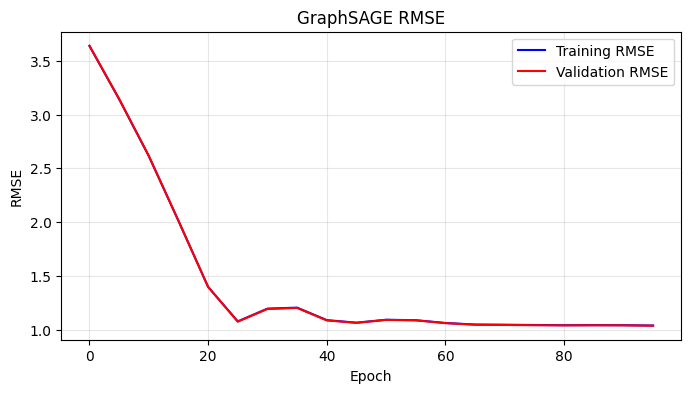

In [53]:
plt.figure(figsize=(8,4))
plt.plot(epochs_recorded, train_rmses, label='Training RMSE',color='blue')
plt.plot(epochs_recorded, val_rmses, label='Validation RMSE', color='red')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('GraphSAGE RMSE')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Load best model
graphsage_model.load_state_dict(torch.load('../models/best_graphsage_model.pth', weights_only=True))
graphsage_test_rmse, graphsage_test_mae = evaluate_model(graphsage_model, test_users, test_movies, test_ratings_tensor, 'GraphSAGE')
print(f"GraphSAGE Test RMSE: {mf_test_rmse:.4f}, MAE: {mf_test_mae:.4f}")

GraphSAGE Test RMSE: 1.0388, MAE: 0.8270


### PinSAGE

In [61]:
# Model Family: Graph Neural Networks
# Architecture: Neural Network
# Variant: Inductive Graph Convolutional Network with Random Walk Sampling
# Use Case: Recommendation Systems, Item-to-Item Recommendations

class SimplePinSAGE(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=32, dropout_rate=0.3):
        super().__init__()
        # Use standard SAGEConv layers but with attention-like features
        self.sage1 = SAGEConv(input_dim, hidden_dim)
        self.sage2 = SAGEConv(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)
        
        # Rating prediction
        self.rating_predictor = nn.Sequential(
            nn.Linear(output_dim * 2, output_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(output_dim, 1)
        )
        
    def forward(self, x, edge_index, user_idx, movie_idx):
        h = self.sage1(x, edge_index).relu()
        h = self.dropout(h)
        h = self.sage2(h, edge_index)
        h = self.dropout(h)
        
        user_repr = h[user_idx]
        movie_repr = h[movie_idx]
        
        rating_input = torch.cat([user_repr, movie_repr], dim=1)
        return self.rating_predictor(rating_input).squeeze()

In [62]:
# Train simplified PinSAGE
simple_pinsage = SimplePinSAGE(input_dim=data.x.shape[1], dropout_rate=0.4)
simple_optimizer = torch.optim.Adam(simple_pinsage.parameters(), lr=0.001)

In [63]:

# Create the models directory in the parent folder
os.makedirs('../models', exist_ok=True)

# Start timing
start_time = time.time()

# Training loop
best_val_rmse = float('inf')
patience_counter = 0

train_losses = []
train_rmses = []
val_rmses = []
epochs_recorded = []
model_saved = False  # Track if model was saved

pbar = tqdm(range(100), desc="Training Simple PinSAGE")

for epoch in pbar:
    simple_pinsage.train()
    simple_optimizer.zero_grad()
    
    pred = simple_pinsage(data.x, data.edge_index, train_users, train_movies + num_users)
    loss = F.mse_loss(pred, train_ratings_tensor)
    loss.backward()
    simple_optimizer.step()
    
    if epoch % 5 == 0:
        simple_pinsage.eval()
        with torch.no_grad():
            train_pred = simple_pinsage(data.x, data.edge_index, train_users, train_movies + num_users)
            train_rmse = torch.sqrt(F.mse_loss(train_pred, train_ratings_tensor)).item()
            
            val_pred = simple_pinsage(data.x, data.edge_index, val_users, val_movies + num_users)
            val_rmse = torch.sqrt(F.mse_loss(val_pred, val_ratings_tensor)).item()
        
        # Store metrics
        train_losses.append(loss.item())
        train_rmses.append(train_rmse)
        val_rmses.append(val_rmse)
        epochs_recorded.append(epoch)
        
        # Update progress bar
        pbar.set_postfix({
            'Train_RMSE': f'{train_rmse:.4f}',
            'Val_RMSE': f'{val_rmse:.4f}',
            'Loss': f'{loss.item():.4f}',
            'Time': f'{time.time() - start_time:.2f}s'
        })
        
        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            torch.save(simple_pinsage.state_dict(), '../models/best_simple_pinsage_model.pth')
            model_saved = True
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= 5:
            pbar.set_description(f"Early stopping at epoch {epoch}")
            break

pbar.close()

# save the final model
if not model_saved:
    torch.save(simple_pinsage.state_dict(), '../models/best_simple_pinsage_model.pth')

total_training_time = time.time() - start_time
print(f"\nTotal training time: {total_training_time:.2f} seconds")


Early stopping at epoch 80:  80%|████████  | 80/100 [07:25<01:51,  5.57s/it, Train_RMSE=1.0586, Val_RMSE=1.0568, Loss=1.8687, Time=445.32s]


Total training time: 445.32 seconds


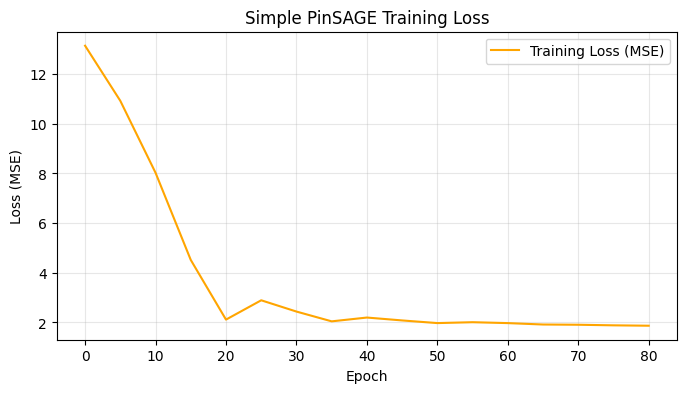

In [64]:
# Plot results
plt.figure(figsize=(8, 4))
plt.plot(epochs_recorded, train_losses, label='Training Loss (MSE)',color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Simple PinSAGE Training Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

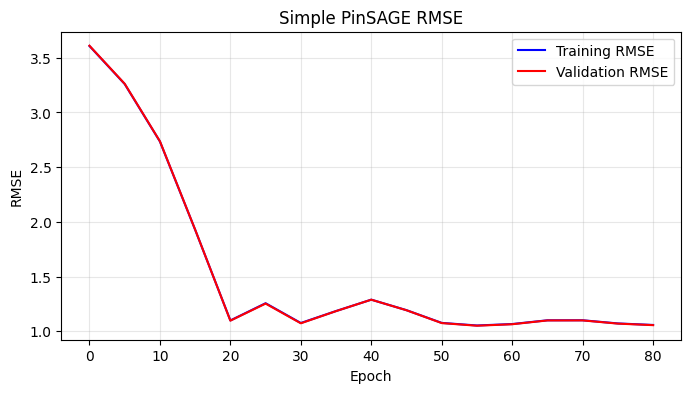

In [65]:
plt.figure(figsize=(8, 4))
plt.plot(epochs_recorded, train_rmses, label='Training RMSE',color='blue')
plt.plot(epochs_recorded, val_rmses, label='Validation RMSE',color='red')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Simple PinSAGE RMSE')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [66]:
# Load best model
simple_pinsage.load_state_dict(torch.load('../models/best_simple_pinsage_model.pth', weights_only=True))
pinsage_test_rmse, pinsage_test_mae = evaluate_model(simple_pinsage, test_users, test_movies, test_ratings_tensor, 'PinSAGE')
print(f"PinSAGE Test RMSE: {pinsage_test_rmse:.4f}, MAE: {pinsage_test_mae:.4f}")

PinSAGE Test RMSE: 1.0517, MAE: 0.8409


### GraphREC

In [50]:
# Model Family: Graph Neural Networks
# Architecture: Neural Network
# Variant: Multi-relational Graph Convolutional Network
# Use Case: Social Recommendation Systems


class GraphRec(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim=64, dropout=0.3):
        super().__init__()
        # Project input features (no need to change dimension if input_dim == hidden_dim)
        self.input_projection = torch.nn.Linear(input_dim, hidden_dim) if input_dim != hidden_dim else torch.nn.Identity()
        
        # Graph convolutional layers
        self.conv1 = GCNConv(hidden_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        
        # Batch normalization
        self.bn1 = torch.nn.BatchNorm1d(hidden_dim)
        self.bn2 = torch.nn.BatchNorm1d(hidden_dim)
        
        # Dropout
        self.dropout = torch.nn.Dropout(dropout)
        
        # Rating predictor
        self.rating_predictor = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim * 2, 64),
            torch.nn.BatchNorm1d(64),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            
            torch.nn.Linear(64, 32),
            torch.nn.BatchNorm1d(32),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            
            torch.nn.Linear(32, 16),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout/2),
            
            torch.nn.Linear(16, 1)
        )
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias)
    
    def forward(self, x, edge_index, user_idx, movie_idx):
        # Project input features (or pass through if same dimension)
        h = self.input_projection(x)
        
        # Apply GNN layers
        h = self.conv1(h, edge_index)
        h = self.bn1(h)
        h = F.relu(h)
        h = self.dropout(h)
        
        h = self.conv2(h, edge_index)
        h = self.bn2(h)
        h = F.relu(h)
        h = self.dropout(h)
        
        # Get user and movie representations
        user_repr = h[user_idx]
        movie_repr = h[movie_idx]
        
        # Predict rating
        rating_input = torch.cat([user_repr, movie_repr], dim=1)
        return self.rating_predictor(rating_input).squeeze()

In [51]:
print(f"data.x shape: {data.x.shape}")
print(f"data.x sample:\n{data.x[:5]}")

data.x shape: torch.Size([20979, 64])
data.x sample:
tensor([[ 0.3076, -2.3540, -0.0580, -0.2141, -0.2369,  1.3911, -0.9447,  0.3475,
         -0.4762, -0.5161,  0.8260, -1.0848, -0.7031, -0.0962,  0.1544,  1.8079,
          0.4271,  0.0163, -1.5492,  0.4210, -0.1848,  0.4414, -0.0300, -0.2400,
         -0.0776, -0.4383,  1.7614, -0.6602,  0.3046,  0.4342, -1.4825,  0.5166,
         -0.6015,  1.0425, -0.4578, -0.8607, -0.1314,  0.6247, -0.1768,  0.7563,
          0.2641,  0.4370, -1.9608,  1.5581,  1.7053, -0.2841, -0.9004,  0.5247,
         -1.2871, -0.8464,  1.0269, -0.0098,  0.0787,  0.2249, -0.2886,  0.1596,
         -1.5281, -1.6119,  0.2070,  0.2425, -1.5697, -1.2816,  0.2390,  0.4330],
        [ 1.6074, -0.1805, -1.3898,  0.9152, -1.8143, -2.2983,  0.2752, -1.4713,
         -0.5670, -0.8305,  0.8953,  0.7884,  0.6824, -0.7199,  0.9281, -0.6738,
         -1.5289, -1.6915, -0.1701, -0.2917, -0.1639,  1.4757,  2.1325, -0.3843,
         -0.2874, -1.1554, -0.9772,  0.9132, -2.2815, -

In [52]:
# Initialize model - since input is 64D, use hidden_dim=64 to avoid unnecessary projection
graphrec_model = GraphRec(
    input_dim=data.x.shape[1],  # 64
    hidden_dim=64,  # Match input dimension
    dropout=0.3
)

print(f"GraphRec has {sum(p.numel() for p in graphrec_model.parameters()):,} parameters")

GraphRec has 19,649 parameters


In [53]:
graphrec_optimizer = torch.optim.AdamW(
    graphrec_model.parameters(), 
    lr=0.001,
    weight_decay=1e-4
)

In [54]:
# Create the models directory in the parent folder
os.makedirs('../models', exist_ok=True)

# Start timing
start_time = time.time()

# Training configuration
num_epochs = 300  # Increased from 100
patience = 20  # Increased from 5 for more stability
eval_interval = 5  # Evaluate every 5 epochs

best_val_rmse = float('inf')
patience_counter = 0
best_epoch = 0

train_losses = []
train_rmses = []
val_rmses = []
epochs_recorded = []

pbar = tqdm(range(num_epochs), desc="Training GraphRec")

for epoch in pbar:
    graphrec_model.train()
    graphrec_optimizer.zero_grad()
    
    pred = graphrec_model(data.x, data.edge_index, train_users, train_movies)
    loss = F.mse_loss(pred, train_ratings_tensor)
    loss.backward()
    graphrec_optimizer.step()
    
    # Evaluate at specified intervals
    if epoch % eval_interval == 0 or epoch == num_epochs - 1:
        graphrec_model.eval()
        with torch.no_grad():
            train_pred = graphrec_model(data.x, data.edge_index, train_users, train_movies)
            train_rmse = torch.sqrt(F.mse_loss(train_pred, train_ratings_tensor)).item()
            
            val_pred = graphrec_model(data.x, data.edge_index, val_users, val_movies)
            val_rmse = torch.sqrt(F.mse_loss(val_pred, val_ratings_tensor)).item()
        
        # Store metrics
        train_losses.append(loss.item())
        train_rmses.append(train_rmse)
        val_rmses.append(val_rmse)
        epochs_recorded.append(epoch)
        
        # Check for improvement
        improved = False
        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            best_epoch = epoch
            torch.save(graphrec_model.state_dict(), '../models/best_graphrec_model.pth')
            patience_counter = 0
            improved = True
        else:
            patience_counter += 1
        
        # Update progress bar
        pbar.set_postfix({
            'Train_RMSE': f'{train_rmse:.4f}',
            'Val_RMSE': f'{val_rmse:.4f}',
            'Best_Val': f'{best_val_rmse:.4f}',
            'Loss': f'{loss.item():.4f}',
            'Patience': f'{patience_counter}/{patience}',
            'Time': f'{time.time() - start_time:.2f}s'
        })
        
        # Early stopping check
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch}")
            print(f"Best validation RMSE: {best_val_rmse:.4f} at epoch {best_epoch}")
            break

pbar.close()

total_training_time = time.time() - start_time
print(f"\nTraining completed!")
print(f"Total training time: {total_training_time:.2f} seconds")
print(f"Best validation RMSE: {best_val_rmse:.4f} achieved at epoch {best_epoch}")
print(f"Model saved to: ../models/best_graphrec_model.pth")

Training GraphRec: 100%|██████████| 300/300 [55:05<00:00, 11.02s/it, Train_RMSE=1.0620, Val_RMSE=1.0635, Best_Val=1.0618, Loss=1.7728, Patience=1/20, Time=3305.30s]


Training completed!
Total training time: 3305.34 seconds
Best validation RMSE: 1.0618 achieved at epoch 295
Model saved to: ../models/best_graphrec_model.pth


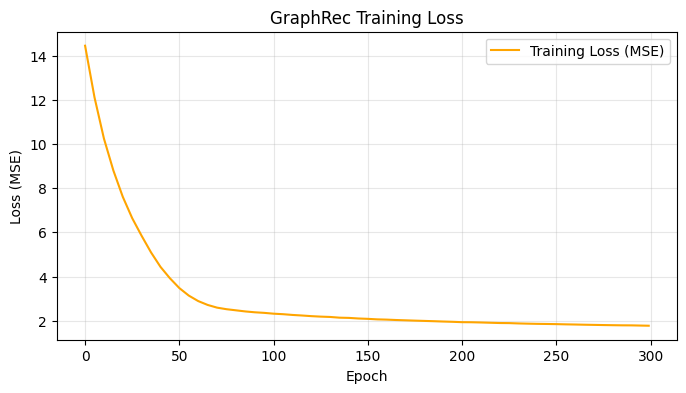

In [55]:
# Plot results
plt.figure(figsize=(8, 4))
plt.plot(epochs_recorded, train_losses, label='Training Loss (MSE)',color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('GraphRec Training Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

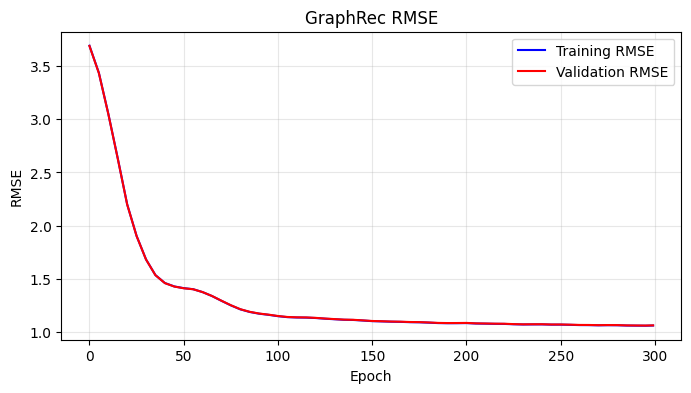

In [56]:
plt.figure(figsize=(8, 4))
plt.plot(epochs_recorded, train_rmses, label='Training RMSE',color='blue')
plt.plot(epochs_recorded, val_rmses, label='Validation RMSE',color='red')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('GraphRec RMSE')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [57]:
def evaluate_model(model, users, movies, ratings_true, model_type):
    model.eval()
    with torch.no_grad():
        if model_type == 'mf':
            user_embs = model.user_embedding.weight
            movie_embs = model.movie_embedding.weight
            pred = (user_embs[users] * movie_embs[movies]).sum(dim=1)
        elif model_type in ['graphsage', 'GraphSEC']:
            # Add offset for movies when calling the model
            pred = model(data.x, data.edge_index, users, movies + num_users)
        else:
            raise ValueError(f"Unknown model type: {model_type}")
    
    rmse = torch.sqrt(F.mse_loss(pred, ratings_true))
    mae = F.l1_loss(pred, ratings_true)
    return rmse.item(), mae.item()

In [58]:
# Load best model
graphrec_model.load_state_dict(torch.load('../models/best_graphrec_model.pth', weights_only=True))
graphrec_test_rmse, graphrec_test_mae = evaluate_model(graphrec_model, test_users, test_movies, test_ratings_tensor, 'GraphSEC')
print(f"GraphSEC Test RMSE: {graphrec_test_rmse:.4f}, MAE: {graphrec_test_mae:.4f}")

GraphSEC Test RMSE: 1.3098, MAE: 1.0983
